## Test cmip6 data


In [10]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import cartopy
#from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import intake
# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util
import nc_time_axis

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

In [11]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

In [12]:
col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")

In [13]:
table_var = {'Amon': 'tas', 
             'Lmon': 'nbp', 
             'Omon': 'fgco2', 
             'fx'  : 'areacella', 
             'Ofx' : 'areacello'
            }

cat_dict = {}
dset_dict = {}

for tab, var in table_var.items():
    print(var)
    cat_dict[var] = col.search(experiment_id='historical', 
                     source_id=['CanESM5', 'CESM2'],
                     table_id=tab,             
                     variable_id=var,
                     member_id = 'r1i1p1f1',
                     grid_label='gn')
    tmp_ds_dict = cat_dict[var].to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': True})
    tmp_ds_dict2 = {} 
    for key in tmp_ds_dict.keys():
        # set the key to just the model name, and keep only relevant dimensions
        new_key = key.split(".")[2]
        for coord in tmp_ds_dict[key].coords:
            if coord not in ['lat','lon','time']:
                tmp_ds_dict[key] = tmp_ds_dict[key].drop(coord)
        tmp_ds_dict2[new_key] = tmp_ds_dict[key]

    dset_dict[var] = tmp_ds_dict2

tas
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 2 group(s)
nbp
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 2 group(s)
fgco2
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 2 group(s)
areacella
Progress: |███████████████████████████████████████████████████████████████████████████████| 10

In [19]:
gmst_dict = {}

for model in dset_dict['tas'].keys():
    gmst_dict[model] = ((dset_dict['tas'][model]['tas'] * 
                         dset_dict['areacella'][model]['areacella']).sum(dim=['lon', 'lat'])/ 
                        dset_dict['areacella'][model]['areacella'].sum(dim=['lon', 'lat'])
                       ).resample(time='1A').mean() - 273.15

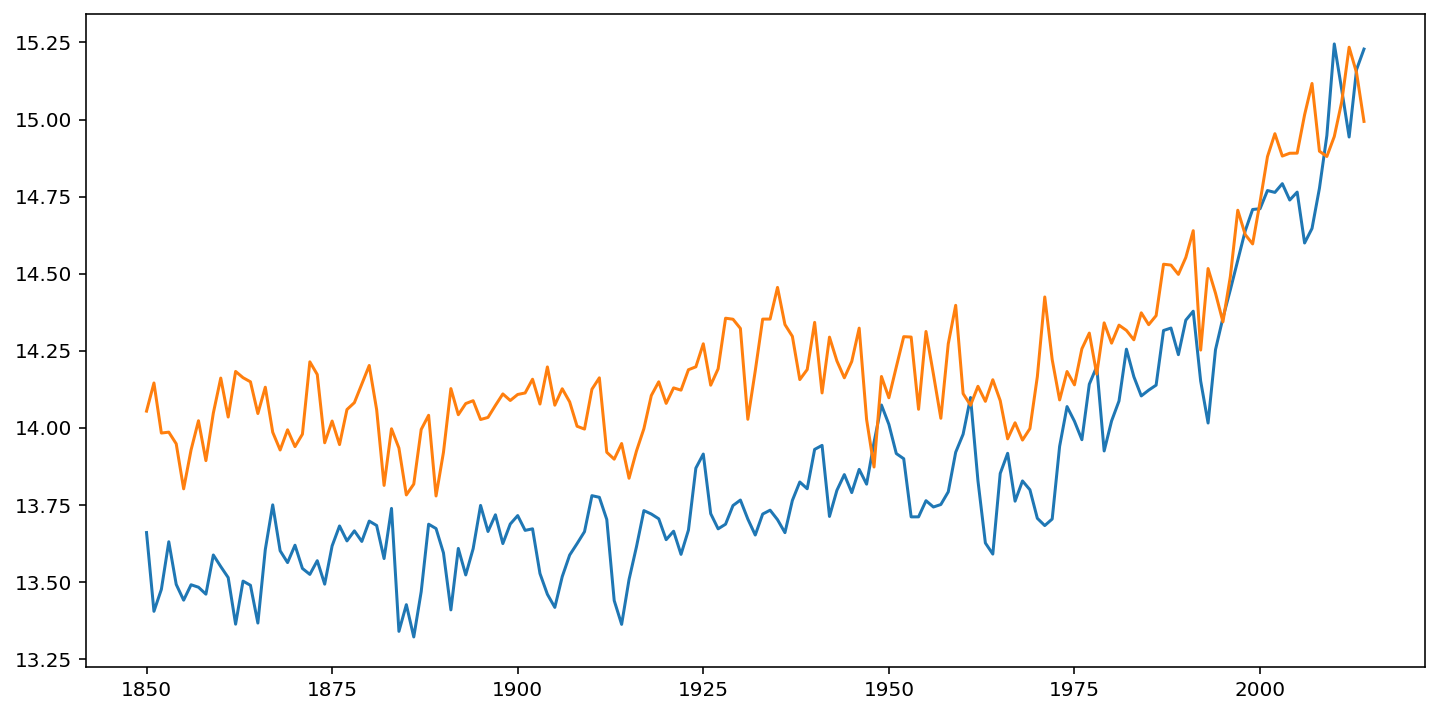

In [20]:
plt.plot(gmst_dict['CanESM5'].time.dt.year, gmst_dict['CanESM5'].squeeze())
plt.plot(gmst_dict['CESM2'].time.dt.year, gmst_dict['CESM2'].squeeze())

In [21]:
names = []
gmsts = []
for model, gmst in gmst_dict.items():
    names.append(model)
    gmsts.append(gmst)

In [22]:
a = xr.concat(gmsts, dim=names)

In [28]:
lcf_dict = {}

for model in dset_dict['fgco2'].keys():
    lcf_dict[model] = ((dset_dict['nbp'][model]['nbp'] * 
                         dset_dict['areacella'][model]['areacella']).sum(dim=['lon', 'lat'])
                       ).resample(time='1A').mean() 

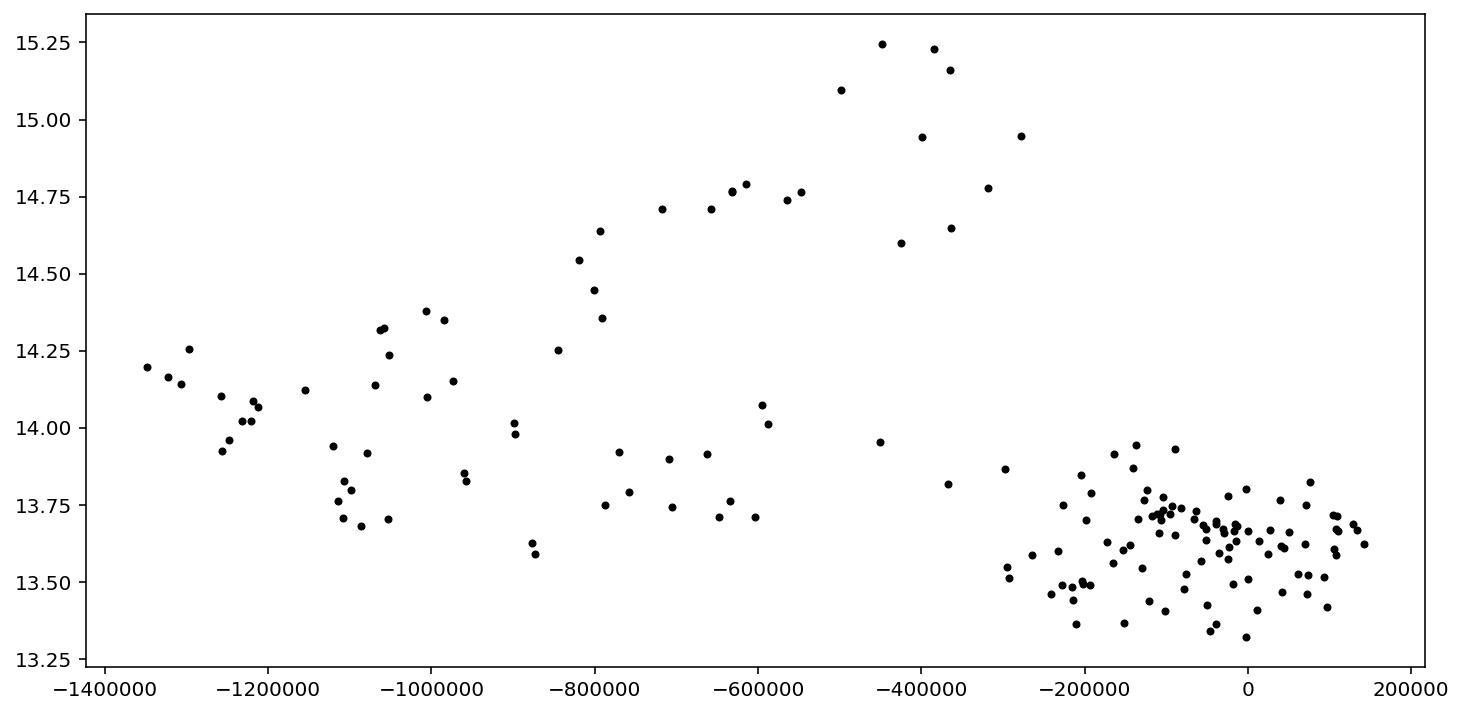

In [29]:
plt.plot(lcf_dict['CanESM5'].cumsum().squeeze(), gmst_dict['CanESM5'].squeeze(), 'k.')

In [49]:
ocf_dict = {}

for model in dset_dict['fgco2'].keys():
    hor_dims = list(set(list(dset_dict['fgco2'][model]['fgco2'].dims)) - set(['time', 'member_id']))
    ocf_dict[model] = ((dset_dict['fgco2'][model]['fgco2'] * 
                         dset_dict['areacello'][model]['areacello']).sum(dim=hor_dims)
                       ).resample(time='1A').mean() 

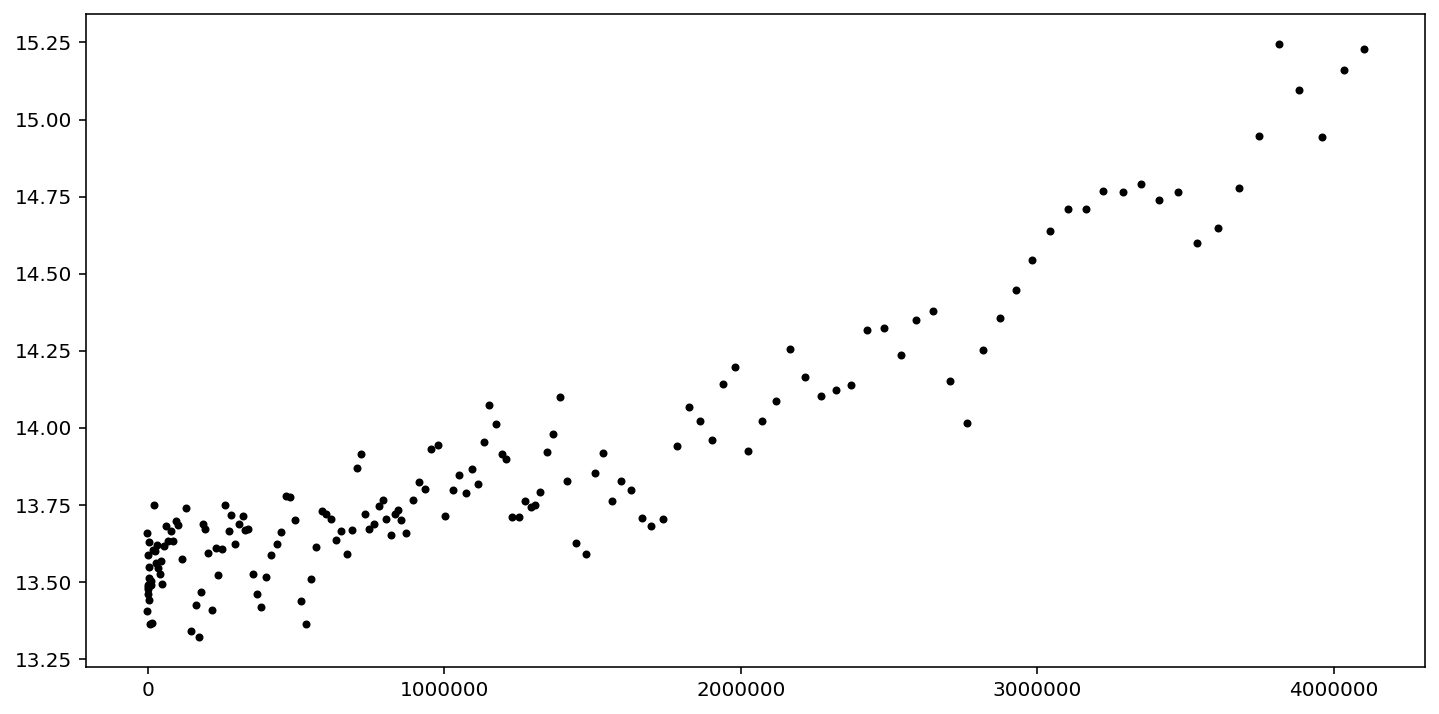

In [50]:
plt.plot(ocf_dict['CanESM5'].cumsum().squeeze(), gmst_dict['CanESM5'].squeeze(), 'k.')